# Notes

We provide this notebook for inference and visualizations. 

You can either load images from a dataloader(see Sec. 1) or from a local path(see Sec. 2).

Welcome to join [IDEA](https://idea.edu.cn/en)([中文网址](https://idea.edu.cn/))!

In [64]:
import os, sys
import torch, json
import numpy as np

from main import build_model_main
from util.slconfig import SLConfig
from datasets import build_dataset
from util.visualizer import COCOVisualizer
from util import box_ops

# 0. Initialize and Load Pre-trained Models

In [65]:
model_config_path = "config/DINO/DINO_4scale_swin.py" # change the path of the model config file
model_checkpoint_path = "result_model/checkpoint0049.pth" # change the path of the model checkpoint
#model_checkpoint_path = "./result_model/checkpoint_best_regular.pth"
# See our Model Zoo section in README.md for more details about our pretrained models.

In [66]:
args = SLConfig.fromfile(model_config_path) 
args.device = 'cuda' 
model, criterion, postprocessors = build_model_main(args)
checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])
_ = model.eval()

use_checkpoint!!!!!!!!!!!!!!!!!!!!!!!!


In [67]:
# load coco names
with open('util/coco_my_id2name.json') as f:
    id2name = json.load(f)
    id2name = {int(k):v for k,v in id2name.items()}

# 1. Visualize images from a dataloader
## 1.1 Load Datasets

In [68]:
args.dataset_file = 'coco'
args.coco_path = "./data" # the path of coco
args.fix_size = False

dataset_val = build_dataset(image_set='val', args=args)   

data_aug_params: {
  "scales": [
    480,
    512,
    544,
    576,
    608,
    640,
    672,
    704,
    736,
    768,
    800
  ],
  "max_size": 1333,
  "scales2_resize": [
    400,
    500,
    600
  ],
  "scales2_crop": [
    384,
    600
  ]
}
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


## 1.2 Get an Example and Visualize it

In [69]:
image, targets = dataset_val[0]

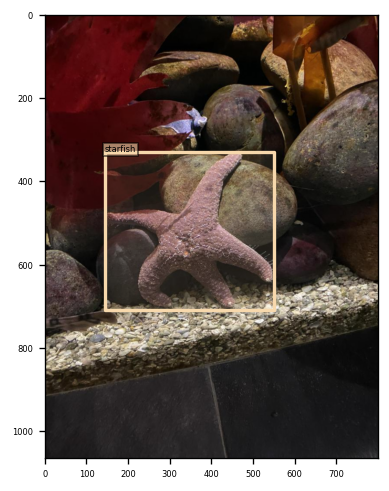

In [70]:
# build gt_dict for vis
box_label = [id2name[int(item)] for item in targets['labels']]
gt_dict = {
    'boxes': targets['boxes'],
    'image_id': targets['image_id'],
    'size': targets['size'],
    'box_label': box_label,
}
vslzr = COCOVisualizer()
vslzr.visualize(image, gt_dict, savedir=None)

## 1.3 Visualize Model Predictions

In [71]:
output = model.cuda()(image[None].cuda())
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

In [72]:
thershold = 0.3 # set a thershold

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

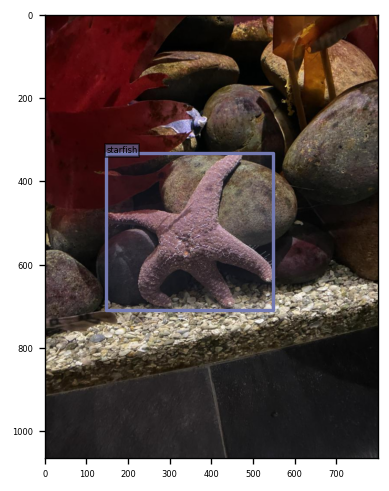

In [73]:
box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': targets['size'],
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None)

# 2. Visualize Custom Images

In [74]:
from PIL import Image
import datasets.transforms as T

In [75]:
image = Image.open("./data/val2017/IMG_8535_MOV-1_jpg.rf.1c1aa55d7b35e08b6760c9cc43d427d0.jpg").convert("RGB") # load image

In [76]:
# transform images
transform = T.Compose([
    # T.RandomResize([800], max_size=1333),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
image, _ = transform(image, None)

In [77]:
# predict images
output = model.cuda()(image[None].cuda())
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

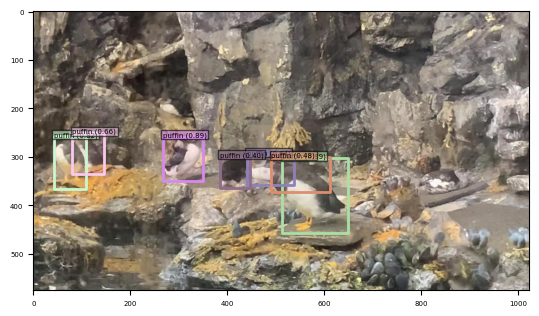

In [78]:
# visualize outputs
thershold = 0.3 # set a thershold

vslzr = COCOVisualizer()

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

box_label = [f"{id2name[int(item)]} ({scores[select_mask][index]:.2f})" for index, item in enumerate(labels[select_mask])]

pred_dict = {
    'boxes': boxes[select_mask],
    'size': torch.Tensor([image.shape[1], image.shape[2]]),
    'box_label': box_label,
}
vslzr.visualize(image, pred_dict, savedir=None, dpi=100)

In [79]:
pred_dict = {
    'boxes': boxes[select_mask],
    'size': torch.Tensor([image.shape[1], image.shape[2]]),
    'box_label': box_label
}

# 3.output correct format of validation prediction

In [80]:
import os
from PIL import Image

def get_images_filenames(dirname):
    # Define the directory containing the images
    directory = dirname

    # Get a list of all files in the directory
    all_files = os.listdir(directory)

    # Filter out only the image files (assuming jpg and png formats for simplicity, but you can expand this)
    image_files = [f for f in all_files if f.endswith('.jpg') or f.endswith('.png')]

    # Read the images into a list and store their file names
    images = []
    filenames = []

    for image_file in image_files:
        # Full path to the image file
        image_path = os.path.join(directory, image_file)
        
        # Open and append the image to the images list
        images.append(Image.open(image_path))
        
        # Append the image filename to the filenames list
        filenames.append(image_file)
    return images, filenames

# Now, 'images' contains the list of images and 'filenames' contains their corresponding file names



In [81]:
images , filenames = get_images_filenames("./data/val2017/")

In [82]:
def predict(src_image):
    image, _ = transform(src_image, None)
    output = model.cuda()(image[None].cuda())
    
    output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]
    
    #thershold = 0.3 # set a thershold


    scores = output['scores']
    labels = output['labels']
    boxes = output['boxes']
    # select_mask = scores > 0

    # labels = labels[select_mask]
    # scores = scores[select_mask]
    # boxes = boxes[select_mask]

    # Multiply the x-coordinates by x_factor
    boxes[:, 0] *= image.shape[2]
    boxes[:, 2] *= image.shape[2]

    # Multiply the y-coordinates by y_factor
    boxes[:, 1] *= image.shape[1]
    boxes[:, 3] *= image.shape[1]

    pred_dict = {
        "boxes": boxes,
        "labels": labels,
        "scores": scores,
    }
    return pred_dict

In [83]:
predict(images[0])

{'boxes': tensor([[513.1188, 302.0104, 648.5753, 456.2430],
         [266.8711, 258.2256, 349.8282, 349.0269],
         [ 42.0616, 257.2410, 109.0262, 365.5116],
         ...,
         [556.2559, 329.1060, 624.1588, 370.6246],
         [405.9310, 428.2991, 451.5251, 480.6448],
         [291.4795, 183.2346, 336.6452, 220.2487]], device='cuda:0'),
 'labels': tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 1, 1, 4, 4, 4, 1, 1, 1,
         4, 1, 3, 4, 3, 3, 4, 1, 4, 3, 1, 4, 1, 4, 3, 1, 4, 1, 4, 4, 3, 4, 4, 1,
         4, 1, 1, 3, 4, 4, 3, 1, 4, 1, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 5, 1, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 5, 2, 1, 1, 4, 1, 4, 4, 4,
         4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 5, 1, 4, 1, 4, 7, 1, 4, 5, 4, 4, 1, 2,
         5, 5, 4, 4, 5, 4, 4, 4, 4, 4, 1, 4, 4, 4, 3, 4, 2, 4, 2, 4, 4, 4, 4, 4,
         1, 4, 3, 4, 2, 4, 4, 4, 1, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 3, 5, 3, 4,
         1, 4, 1, 3, 3, 1, 4, 4, 4, 4, 4, 2, 4, 4, 1, 7, 4, 4, 4, 4, 4, 7, 

In [84]:
id2name

{0: 'creatures',
 1: 'fish',
 2: 'jellyfish',
 3: 'penguin',
 4: 'puffin',
 5: 'shark',
 6: 'starfish',
 7: 'stingray'}

In [85]:
result_dict = {}
for i in range(len(images)):
    pred_dict = predict(images[i])
    result_dict[filenames[i]] = pred_dict

In [86]:
result_dict

{'IMG_8535_MOV-1_jpg.rf.1c1aa55d7b35e08b6760c9cc43d427d0.jpg': {'boxes': tensor([[513.1188, 302.0104, 648.5753, 456.2430],
          [266.8711, 258.2256, 349.8282, 349.0269],
          [ 42.0616, 257.2410, 109.0262, 365.5116],
          ...,
          [556.2559, 329.1060, 624.1588, 370.6246],
          [405.9310, 428.2991, 451.5251, 480.6448],
          [291.4795, 183.2346, 336.6452, 220.2487]], device='cuda:0'),
  'labels': tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 1, 1, 4, 4, 4, 1, 1, 1,
          4, 1, 3, 4, 3, 3, 4, 1, 4, 3, 1, 4, 1, 4, 3, 1, 4, 1, 4, 4, 3, 4, 4, 1,
          4, 1, 1, 3, 4, 4, 3, 1, 4, 1, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
          4, 4, 5, 1, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 5, 2, 1, 1, 4, 1, 4, 4, 4,
          4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 5, 1, 4, 1, 4, 7, 1, 4, 5, 4, 4, 1, 2,
          5, 5, 4, 4, 5, 4, 4, 4, 4, 4, 1, 4, 4, 4, 3, 4, 2, 4, 2, 4, 4, 4, 4, 4,
          1, 4, 3, 4, 2, 4, 4, 4, 1, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 3, 5, 3, 4,

In [87]:
def tolist(result_dict):
    for key, value in result_dict.items():
        for subkey, tensor_value in value.items():
            if torch.is_tensor(tensor_value):
                value[subkey] = tensor_value.tolist()

In [88]:
tolist(result_dict)
result_dict

{'IMG_8535_MOV-1_jpg.rf.1c1aa55d7b35e08b6760c9cc43d427d0.jpg': {'boxes': [[513.1187744140625,
    302.01043701171875,
    648.5753173828125,
    456.2430419921875],
   [266.8711242675781,
    258.2256164550781,
    349.8282165527344,
    349.02691650390625],
   [42.0616455078125,
    257.2409973144531,
    109.02615356445312,
    365.5115966796875],
   [80.1125259399414, 250.5830078125, 146.20590209960938, 335.66656494140625],
   [439.9586486816406,
    294.927001953125,
    538.1209106445312,
    358.14154052734375],
   [491.4007263183594,
    300.2103271484375,
    611.3401489257812,
    373.5240478515625],
   [384.7291259765625, 299.4042663574219, 446.87158203125, 364.6230773925781],
   [443.437744140625,
    296.11187744140625,
    608.2320556640625,
    368.6969909667969],
   [559.6958618164062,
    299.24029541015625,
    614.8842163085938,
    357.5338134765625],
   [259.8472900390625, 178.50537109375, 317.3255615234375, 227.24217224121094],
   [258.9896545410156,
    178.826065

In [89]:
with open('val_result.json', 'w') as file:
    json.dump(result_dict, file)

# 4. output correct format of test predictions

In [90]:
images, filenames = get_images_filenames("./data/test")

In [91]:
test_result_dict = {}
for i in range(len(images)):
    test_pred_dict = predict(images[i])
    test_result_dict[filenames[i]] = test_pred_dict



In [92]:
tolist(test_result_dict)

In [93]:
with open('Output_json_for_test.json', 'w') as file:
    json.dump(test_result_dict, file)